# July 28, August 1,3,8, 2022: create new set of rois from center coordinates

The previous code did not get saved, so doing again on August 3, 2022.

In [1]:
import os 
import sys
from os.path import join as pjoin
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle, random

from nltools import mask
from nilearn import image, masking

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/aug22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## set of rois

In [2]:
set_name = 'mashid'
mask_dir = f"{proj_dir}/data/rois/{set_name}/individual_nifti_files"
roi_set_file = f"{proj_dir}/data/rois/{set_name}/roi_set_{set_name}.csv"

roi_set_df = pd.read_csv(roi_set_file)
def str_to_list(s): 
    a = s.strip('][').split(', ')
    if len(a) == 3:
        return list(map(int, a))
    else:
        return []
roi_set_df['coordinates'] = roi_set_df['coordinates'].apply(str_to_list)
roi_set_df

,network,roi_name,coordinates
0,Salience,Frontoinsular cortex L,"[-34, 18, 4]"
1,Salience,Frontoinsular cortex R,"[34, 22, 4]"
2,Salience,Dorsal anterior cingulate cortex,"[2, 10, 40]"
3,Salience,Temporo-parietal junction L,"[-62, -26, 36]"
4,Salience,Temporo-parietal junction R,"[62, -26, 36]"
5,Salience,Inferotemporal cortex L,"[-54, -62, -4]"
6,Salience,Inferotemporal cortex R,"[54, -54, -8]"
7,Salience,Precentral L,"[-26, -6, 64]"
8,Salience,Precentral R,"[26, -2, 64]"
9,Salience,Dorsolateral prefrontal cortex L,"[-38, 42, 24]"


In [3]:
radius = 5 # mm
final_mask_file = f"{mask_dir}/../final_mask.nii.gz"
if not os.path.exists(final_mask_file):
    for idx, row in tqdm(roi_set_df.iterrows()):
        if len(row['coordinates']) != 3: continue

        prefix = f"{mask_dir}/{row['roi_name']}.nii.gz"
        if idx == 0:
            final_mask = mask.create_sphere(row['coordinates'], radius=radius)
        else:
            roi_mask = mask.create_sphere(row['coordinates'], radius=radius)

            # step1: find intersection
            intersect_mask = masking.intersect_masks(
                [image.binarize_img(final_mask), roi_mask],
                threshold=1,
                connected=False
            )

            # step2: remove intersection from the roi_mask
            roi_mask = image.math_img(
                f'img1 - img2',
                img1=roi_mask,
                img2=intersect_mask
            )

            # step3: then include the roi into final_mask
            final_mask = image.math_img(
                f'img1 + {idx+1}*img2',
                img1=final_mask,
                img2=roi_mask
            )
    final_mask.to_filename(final_mask_file)

else:
    final_mask = image.load_img(final_mask_file)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.])

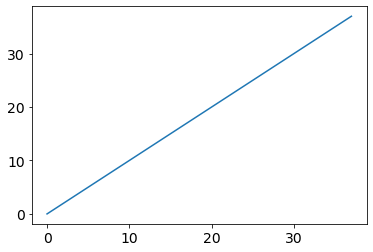

In [4]:
plt.plot(np.unique(final_mask.get_fdata()))

np.unique(final_mask.get_fdata())

individual rois may intersect if we simply add them to create a `final_mask`.
we avoid this by subtracting the intersection from the newly added roi and then adding the remaining roi in the `final_mask`.

the plot verifies that `final_mask` contains numbers only upto 37; number of rois, and individual rois do not intersect in the `final_mask`. 

In [5]:
'''
good voxels

basic step to be taken from the script:
/home/govindas/vscode-BSWIFT-mnt/MAX/scripts/Murty_Final/ROI_analysis/trial_level/FNSandFNT/MAX_fMRI_Analysis_neutral_deconv_reducedRuns.sh
'''

main_mask_path = (
    f"/home/govindas/vscode-BSWIFT-mnt/MAX"
    f"/dataset/preproc/masksAndCensors"
)

for subj in tqdm(os.listdir(main_mask_path)):
    mask_path = (
        f"{main_mask_path}/{subj}"
    )

    mask_goodVoxels_file = f"{mask_path}/mask_{set_name}_goodVoxels.nii.gz"
    if os.path.exists(mask_goodVoxels_file): continue
    mask_goodVoxels = image.math_img(
        f'img1 * img2 * img3',
        img1=f"{mask_path}/goodVoxelsMask.nii.gz",
        img2=f"{mask_path}/commonVoxelsMask.nii.gz",
        img3=f"{final_mask_file}"
    )    
    mask_goodVoxels.to_filename(mask_goodVoxels_file)

  0%|          | 0/109 [00:00<?, ?it/s]

## trial level analysis responses

In [7]:
'''
run in terminal:
bash runDeconvolve.sh
'''

'\nrun in terminal:\nbash runDeconvolve.sh\n'

In [8]:
main_data_dir = (
    f"/home/govindas/network_dynamics/data/max"
    f"/neutral_runs_trial_level_FNSandFNT/{set_name}"
)

class ARGS(): pass
args = ARGS()

args.TRIAL_LEN = 14
args.LABELS = [0, 1] #safe, threat
args.LABEL_NAMES = ['FNS#', 'FNT#']

args.SEED = 74
np.random.seed(args.SEED)

args.subjects = os.listdir(main_data_dir)
random.Random(args.SEED).shuffle(args.subjects)

'''
exploratory dataset
'''
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]
X, _, _ = dataset_utils.get_max_trial_level_responses(
    args, 
    main_data_dir,
    args.explor_subjects
)

with open(f"{proj_dir}/data/max/desc-exploratory_data_trial_level_responses_rois-{set_name}.pkl", 'wb') as f:
    pickle.dump(X, f)

100%|██████████| 27/27 [00:04<00:00,  5.63it/s]
